In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np 
from jax import vmap, lax, jit 
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.special import gamma
from jax.scipy.linalg import cholesky
from functools import partial
from typing import NamedTuple
from flax import struct 
import flax.linen as nn 

plt.rcParams['font.size'] = 20

In [2]:
def sigmoid_log(x): 
    return x / (x + 1) 

NL_REGISTRY = {
    'sigmoid_log': sigmoid_log,
    'relu': jax.nn.relu,
    'tanh': jax.nn.tanh,
    'id': lambda x : x
}

class HyperParams(NamedTuple):
    N: int = 100 # number of odorants 
    n: int = 2 # sparsity of odor vectors--only applies for the Qin et al 2019 odor model 
    M: int = 30 # number of odorant receptors
    O: int = 300 # number of olfactory receptor neurons 
    P: int = 1000 # number of samples when we compute MI
    window: int = 32 # this should be set to jnp.round(jnp.sqrt(P) + 0.5).astype(int) but doing this dynamically makes hp not hashable. So change it when you change P!

    sigma_0: float = 0.01 # neural noise in naive Gaussian neural model 
    sigma_c: float = 2.0 # std_dev of log normal Qin et al 2019 odorant model 

    nonlinearity: str = 'sigmoid_log'

    F_max: float = 25.0
    n: int = 4
    
@struct.dataclass
class Params: 
    W: jnp.ndarray
    E: jnp.ndarray
    kappa_inv: jnp.ndarray
    eta: jnp.ndarray # these are not going to be changed during training, but you can't hash a tuple with jax arrays, so here they shall live. 
    

class T_estimator(nn.Module):
    hidden_dim: int = 128

    @nn.compact
    def __call__(self, c, r):
        # Concatenate c (N,) and r (O,) -> (N + O)
        x = jnp.concatenate([c, r])
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        return nn.Dense(1)(x)
    
@struct.dataclass
class TrainingState:
    p: any           # Your primal parameters
    Tp: any          # MINE network parameters
    key: jax.Array   # PRNG key
    metrics: dict 

In [3]:
def init(rng, scale=1, hp=None, sigma_kappa_inv=4.0, rho=0) -> Params: 
    if hp is None: 
        hp = HyperParams() 
    W_key, E_key, z_key, eta_key = jax.random.split(rng, 4) 
    W = jnp.clip(scale * jax.random.gamma(W_key, a=1, shape=(hp.M, hp.N)), min=1e-6, max=1-1e-6)
    E  = jnp.repeat(jnp.eye(hp.M), hp.O//hp.M, axis=0) # this is a canonical initialization
    # kappa_inv = jax.random.lognormal(kappa_inv_key, sigma=sigma_kappa_inv, shape=(hp.M, hp.N)) # see "Olfactory Encoding Model" in Reddy and Zak 2018
    eta = jax.random.lognormal(eta_key, shape=(hp.M, hp.N))
    z = jax.random.normal(z_key, shape=(hp.M, hp.N)) 
    kappa_inv = jnp.exp(sigma_kappa_inv * (rho * jnp.log(eta) + jnp.sqrt(1 - rho**2) * z))
    return hp, Params(W, E, kappa_inv, eta)

In [4]:
def draw_c_sparse_log_normal(subkey, hp): 
    c = jnp.zeros(hp.N)
    sub1, sub2 = jax.random.split(subkey) 
    non_zero_indices = jax.random.choice(sub1, hp.N, shape=(hp.n,), replace=False)
    concentrations = jax.random.lognormal(sub2, sigma=hp.sigma_c, shape=(hp.n,))
    c = c.at[non_zero_indices].set(concentrations)
    return c

def draw_cs_sparse_log_normal(subkey, hp):
    keybatch = jax.random.split(subkey, hp.P)
    cs = vmap(draw_c_sparse_log_normal, in_axes=(0, None))(keybatch, hp).T
    return cs

def compute_receptor_activity(subkey, hp, p, c):
    pre_activations = p.W @ c
    nl = NL_REGISTRY[hp.nonlinearity]
    r = nl(pre_activations) + hp.sigma_0 * jax.random.normal(subkey, shape=pre_activations.shape) 
    return r

def compute_linear_filter_activity(subkey, hp, p, c):
    receptor_activations = p.W @ c # p.W is receptor x odorant 
    c_AMP = p.E @ receptor_activations # p.E is neuron x receptor 
    nl = NL_REGISTRY[hp.nonlinearity] 
    r = nl(c_AMP) + hp.sigma_0 * jax.random.normal(subkey, shape=c_AMP.shape)
    return r

def compute_osn_firing_rate_with_antagonism(hp, p, c):
    '''generalized version of equation 14 in Reddy, Zak et al. 2018. eta and kappa_inv are receptor x odorant, and the gene expression matrix p.E is neuron x receptor''' 
    receptor_induced_activities = p.E @ (jnp.matmul((p.eta * p.kappa_inv), c) / (1 + jnp.matmul(p.kappa_inv, c))) 
    denominator = 1 + receptor_induced_activities**-hp.n 
    F = hp.F_max / denominator
    return F

def compute_osn_firing_with_antagonism(hp, p, c, subkey):
    firing_rate = compute_osn_firing_rate_with_antagonism(hp, p, c)
    # firing = jax.random.poisson(subkey, lam=firing_rate)
    firing = firing_rate + hp.sigma_0 * jax.random.normal(subkey, shape=firing_rate.shape)
    return firing # this should be neuron x samples, where c is odorants x samples 

# @partial(jit, static_argnames=['hp'])
def compute_entropy(r, hp: HyperParams):
    entropy = compute_sum_of_marginal_entropies(r, hp) - compute_information(r)
    return entropy

def compute_sum_of_marginal_entropies(r, hp):
    compute_entropy_vmap = vmap(vasicek_entropy, in_axes=(0, None))
    marginal_entropies = compute_entropy_vmap(r, hp)
    return jnp.sum(marginal_entropies)

def vasicek_entropy(X, hp): # see https://github.com/scipy/scipy/blob/main/scipy/stats/_entropy.py#L378
    n = X.shape[-1]
    X = jnp.sort(X, axis=-1)
    X = pad_along_last_axis(X, hp.window)
    start1 = 2 * hp.window
    length = hp.P
    differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
    logs = jnp.log(n / (2 * hp.window) * differences)
    return jnp.mean(logs, axis=-1)

def pad_along_last_axis(X, window):
    first_value = X[0]
    last_value = X[-1]
    # Use `lax.full_like` to create padded arrays
    Xl = lax.full_like(x=jnp.empty((window,)), fill_value=first_value)
    Xr = lax.full_like(x=jnp.empty((window,)), fill_value=last_value)
    return jnp.concatenate((Xl, X, Xr))

def compute_information(r): 
    M, P = r.shape
    G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1) # this is just ranking the data and making it normally distributed. 
    bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2)) 
    cov_matrix = jnp.cov(G, rowvar=False)
    chol_decomp = cholesky(cov_matrix)
    log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
    I = -(log_det - bias_correction) # remember: entropy overall is sum of marginals minus information. 
    return I

# @partial(jax.jit, static_argnames=['hp'])
def entropy_loss(p, hp, cs, subkey):
    r = compute_linear_filter_activity(subkey, hp, p, cs)
    e = compute_entropy(r, hp) 
    return -e 

def jensen_shannon_loss(p, Tp, hp, cs, key): 
    key, subkey_firing, subkey_shuffle = jax.random.split(key, 3) 
    r = compute_osn_firing_with_antagonism(hp, p, cs, subkey_firing)
    r_shuffled = jax.random.permutation(subkey_shuffle, r, axis=1) 
    
    T_joint = jax.vmap(T_estimator().apply, in_axes=(None, 1, 1))(
        Tp, cs, r
    )  
    T_marginal = jax.vmap(T_estimator().apply, in_axes=(None, 1, 1))(
        Tp, cs, r_shuffled 
    ) 

    mi_estimate = jnp.mean(-jax.nn.softplus(-T_joint)) - jnp.mean(jax.nn.softplus(T_marginal))
    return - mi_estimate

In [5]:
# @partial(jax.jit, static_argnames=('hp', 'phi', 'psi'))
def update_params_T(p, Tp, hp, cs, key, phi, psi, gamma_p, gamma_T):
    # Split keys
    key, loss_key = jax.random.split(key)

    # Compute gradients for MINE network (T) and model params (E)
    mi_estimate, grads = jax.value_and_grad(
        jensen_shannon_loss, argnums=(0, 1)
    )(p, Tp, hp, cs, loss_key)

    grads_p, grads_T = grads 

    # Update MINE network (T)

    Tp = jax.tree.map(
    lambda param, grad: param - gamma_T * grad,
    Tp,
    grads_T
    )
    # natural gradient in dual space is equivalent to mirror descent in primal space. A "straight through" trick. 
    #  phi:unconstrained --> constrained, psi is inverse of phi. 
    # see https://vene.ro/blog/mirror-descent.html#generalizing-the-projected-gradient-method-with-divergences for a very clear exposition

    U_current = psi(p.E) # map to dual space 
    U_new = U_current - gamma_p * grads_p.E # grads_p.E is correctly with respect to the primal parameters and evaluated on the primal parameters 
    E_new = phi(U_new) # map back to primal space 
    p = p.replace(E=E_new) 

    return p, Tp, mi_estimate

def update_params(p, hp, cs, key, phi, psi, gamma_p, gamma_T, loss):
    # Split keys
    key, loss_key = jax.random.split(key)

    # Compute gradients for MINE network (T) and model params (E)
    mi_estimate, grads_p = jax.value_and_grad(
        loss, argnums=(0)
    )(p, hp, cs, loss_key) # loss needs to have this signature 

    # natural gradient in dual space is equivalent to mirror descent in primal space. A "straight through" trick. 
    #  phi:unconstrained --> constrained, psi is inverse of phi. 
    # see https://vene.ro/blog/mirror-descent.html#generalizing-the-projected-gradient-method-with-divergences for a very clear exposition

    U_current = psi(p.E) # map to dual space 
    U_new = U_current - gamma_p * grads_p.E # grads_p.E is correctly with respect to the primal parameters and evaluated on the primal parameters 
    E_new = phi(U_new) # map back to primal space 
    p = p.replace(E=E_new) 

    return p, mi_estimate

def scan_step(state, hp, phi, psi, gamma_p, gamma_T, loss=None): 
    key, subkey_odors, subkey_loss = jax.random.split(state.key, 3) 
    cs = draw_cs_sparse_log_normal(subkey_odors, hp)
    if loss is None: 
        p_new, Tp_new, mi_estimate = update_params_T(state.p, state.Tp, hp, cs, subkey_loss, phi, psi, gamma_p, gamma_T)
    else: 
        p_new, mi_estimate = update_params(state.p, hp, cs, subkey_loss, phi, psi, gamma_p, gamma_T, loss)
        Tp_new = 0 
    new_metrics = {'mi': mi_estimate}
    return TrainingState(p_new, Tp_new, key, new_metrics), new_metrics 

# @partial(jax.jit, static_argnames=('hp', 'epochs_per_scan'))
def scan_phase(state, hp, phi, psi, gamma_T, gamma_p, epochs_per_scan, loss):
    """Process multiple epochs in a single scanned phase"""
    # Scan over epochs_per_scan steps

    def scan_closure(state, _): # this is just a trick so you can pass hp into your scan_step. 
        state, new_metrics = scan_step(state, hp, phi, psi, gamma_p, gamma_T, loss)
        return state, new_metrics 
        
    final_state, metrics = jax.lax.scan(
        scan_closure,
        state,
        xs=None,
        length=epochs_per_scan
    )
    return final_state, metrics

def flatten_metrics(metrics_list):
    """Convert list of metric dicts to dict of arrays."""
    flattened = {k: [] for k in metrics_list[0].keys()}  # Initialize with keys
    for metrics in metrics_list:
        for k, v in metrics.items():
            flattened[k].extend(v)
    return {k: jnp.array(v) for k, v in flattened.items()} 

def train_natural_gradient_scan_over_epochs(initial_state, hp, phi, psi, gamma_p, gamma_T, loss, scans=2, epochs_per_scan=2):
    all_metrics = [] 
    for scan_idx in range(scans):
        # Run scanned phase
        state, scan_metrics = scan_phase(
            initial_state, hp, phi, psi, gamma_T, gamma_p, epochs_per_scan, loss
        )
        scan_metrics = jax.device_get(scan_metrics)  # Move from device to host

        all_metrics.append(scan_metrics)
        if scan_idx % 10 == 0:
            avg_mi = jnp.mean(jnp.array(scan_metrics['mi']))
            print(f"Scan {scan_idx}: Avg MI {avg_mi:.3f}")
        initial_state = state

    return initial_state, flatten_metrics(all_metrics) 

In [6]:
# for x >= 0: use phi = jnp.exp, psi = jnp.log 
# for x \in [0, 1] use below
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    x = jnp.clip(x, min=1e-6, max=1-1e-6)
    return jnp.log(x / (1 - x))

def phi(u): 
    return jax.nn.softmax(u, axis=1)

def psi(x): 
    return jnp.log(jnp.clip(x, min=1e-6, max=1-1e-6))

In [94]:
key = jax.random.key(1) 
key, *subkeys = jax.random.split(key, 6)
hp = HyperParams(M=2, O=2, P=1000, sigma_0=0.01) 
hp, p_init = init(subkeys[0], hp=hp, scale=.1)
T = T_estimator() 
c = draw_c_sparse_log_normal(subkeys[1], hp) 
r = compute_osn_firing_with_antagonism(hp, p_init, c, subkeys[2]) 
Tp_init = T.init(subkeys[3], c, r) # this is for variational MI estimation 
Tp_init = 0 # this is a dummy for Gaussian MI estimation (not variational, so no T network needed)
p_init = p_init.replace(E = phi(.5 + .1 * jax.random.normal(subkeys[4], shape=p_init.E.shape))) 
init_state = TrainingState(p_init, Tp_init, key, metrics={'mi': 0.0})
gamma_T = 1e-3
gamma_p = 1e-1
scans = 20
epochs_per_scan = 500

In [95]:
state, metrics = train_natural_gradient_scan_over_epochs(init_state, hp, phi, psi, gamma_p, gamma_T, entropy_loss, scans, epochs_per_scan)

Scan 0: Avg MI 2.578
Scan 10: Avg MI 2.534


In [77]:
def plot_expression(E_init, E_final, mis): 
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(E_init[:, 0], E_init[:, 1], alpha=0.7, label='E_init')
    axs[0].scatter(E_final[:, 0], E_final[:, 1], alpha=0.7, label='E_final') 
    # axs[0].hist(E_init[:, 0], alpha=0.7, label=r'$(E_{init})_{i, 0}$')
    # axs[0].hist(E_final[:, 0], alpha=0.7, label=r'$(E_{final})_{i, 0}$')
    axs[0].set_xlabel(r'$E_{i, 1}$')
    axs[0].set_ylabel(r'$E_{i, 2}$')
    axs[0].legend()
    axs[0].set_title('E_i')
    axs[1].plot(mis) 
    return fig, axs

In [86]:
def plot_activity(p_init, p_final, hp, mis, key): 
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    E_init = p_init.E 
    E_final = p_final.E 
    axs[0].scatter(E_init[:, 0], E_init[:, 1], alpha=0.7, label='E_init')
    axs[0].scatter(E_final[:, 0], E_final[:, 1], alpha=0.7, label='E_final') 
    # axs[0].hist(E_init[:, 0], alpha=0.7, label=r'$(E_{init})_{i, 0}$')
    # axs[0].hist(E_final[:, 0], alpha=0.7, label=r'$(E_{final})_{i, 0}$')
    axs[0].set_xlabel(r'$E_{i, 1}$')
    axs[0].set_ylabel(r'$E_{i, 2}$')
    axs[0].legend()
    axs[0].set_title('E_i')
    key, *subkeys = jax.random.split(key, 4) 
    cs = draw_cs_sparse_log_normal(subkeys[0], hp)
    r_init = compute_linear_filter_activity(subkeys[1], hp, p_init, cs)
    r_final = compute_linear_filter_activity(subkeys[2], hp, p_final, cs)
    axs[1].scatter(r_init[0], r_init[1], alpha=0.7, label='r_init')
    axs[1].scatter(r_final[0], r_final[1], alpha=0.7, label='r_final')
    axs[1].legend()
    axs[1].set_title('neural activity') 
    axs[2].plot(mis) 
    return fig, axs, r_init, r_final 

In [87]:
p_init.E

Array([[0.49919617, 0.5008038 ],
       [0.47302294, 0.5269771 ]], dtype=float32)

In [88]:
p_split = p_init
p_split = p_split.replace(E = jnp.eye(2))

In [89]:
p_one = state.p.replace(E = jnp.array([[1, 0], [1, 0]]))

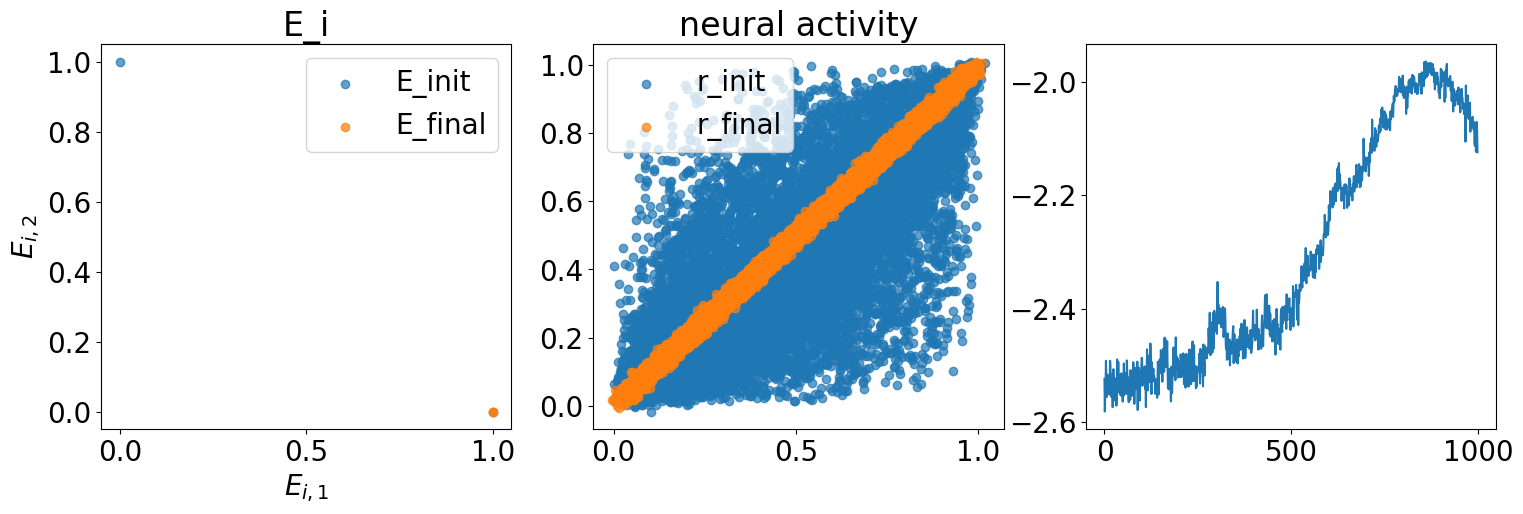

In [90]:
fig, axs, r_init, r_final = plot_activity(p_split, p_one, hp, -1 * metrics['mi'], key=jax.random.key(0)) 

In [92]:
compute_entropy(r_final, hp)

Array(-2.4508443, dtype=float32)

In [93]:
compute_entropy(r_init, hp) 

Array(-0.429996, dtype=float32)

(array([47., 25., 13.,  8.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([0.00086972, 0.0529457 , 0.10502168, 0.15709765, 0.20917363,
        0.2612496 , 0.31332558, 0.36540157, 0.41747755, 0.46955353,
        0.52162951]),
 <BarContainer object of 10 artists>)

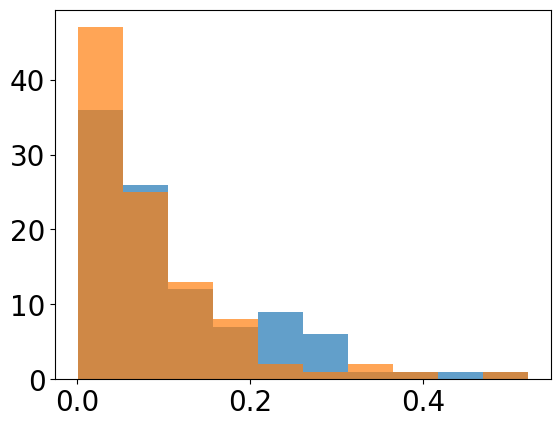

In [67]:
fig, ax = plt.subplots()
_, bins, _=  ax.hist(p_init.W[0], alpha=0.7)
ax.hist(p_init.W[1], alpha=0.7, bins=bins)

In [64]:
tmp[3]

IndexError: tuple index out of range